# Decomposição de séries temporais e modelos clássicos

Nesse capítulo, vamos começar a usar um dataset mais realista, com dados simulando vendas diárias de uma empresa de varejo. 

Vamos aprender os seguintes pontos:

* Definição de séries integradas, e uso de diferenciação
* Modelos estatísticos clássicos: modelos de suavização exponencial e modelos autoregressivos (AR)
* Como usar esses modelos com a biblioteca `sktime`


## Importando dados

Para acessar os dados, vamos usar a classe `SyntheticRetail` da biblioteca `tsbook`, que contém dados simulados de vendas diárias de uma empresa de varejo.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

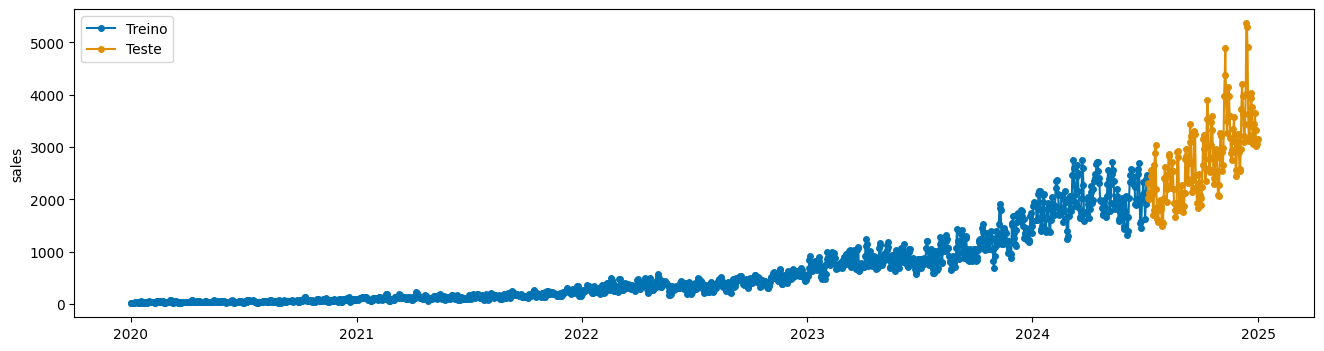

In [1]:
from tsbook.datasets.retail import SyntheticRetail
from sktime.utils.plotting import plot_series

dataset = SyntheticRetail("univariate")
y_train, y_test = dataset.load("y_train", "y_test")

plot_series(y_train, y_test, labels=["Treino", "Teste"])

Os dados são diários, e vemos que sempre positivos. Também notamos que existe alguma sazonalidade, aparentemente algo mensal e anual, que aumenta de magnitude ao longo do tempo.

Algo que deve chamar a atenção nesse gráfico é que a magnitude da série temporal está aumentando ao longo do tempo. Isso não deve passar desapercebido, pois é um ponto importante para entendermos o que vem a seguir.


## Auto-correlação

É interessante entender o quanto de informação o passado de uma série temporal carrega sobre o seu futuro. Uma maneira de capturar essa relação (considerando variações lineares) é através da auto-correlação. A autocorrelação para um determinado lag $k$ é definida como:

$$
\text{Corr}(Y_t,Y_{t-k})=\frac{\text{Cov}(Y_t,Y_{t-k})}{\sqrt{\text{Var}(Y_t)\text{Var}(Y_{t-k})}} = \frac{E[(Y_t - \mu)(Y_{t-k} - \mu)]}{\sqrt{\text{Var}(Y_t)\text{Var}(Y_{t-k})}}
$$

Em outras palavras, quando o valor em $k$ observações atrás está acima (ou abaixo) da média, o valor atual também tende a estar acima (ou abaixo) da média?

Com `plot_correlations`, podemos visualizar algumas informações úteis:

1. No plot superior, vemos a série temporal original.
2. No canto inferior esquerdo, temos o gráfico de autocorrelação (ACF), que mostra a correlação entre a série temporal e suas versões defasadas (lags). Valores próximos de 1 ou -1 indicam uma forte correlação positiva ou negativa, respectivamente.
3. No canto inferior direito, temos o gráfico de autocorrelação parcial (PACF), que mostra a correlação entre a série temporal e suas versões defasadas, controlando para as correlações intermediárias. É útil para entender o efeito isolado de um lag.

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_35862/2914460266.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


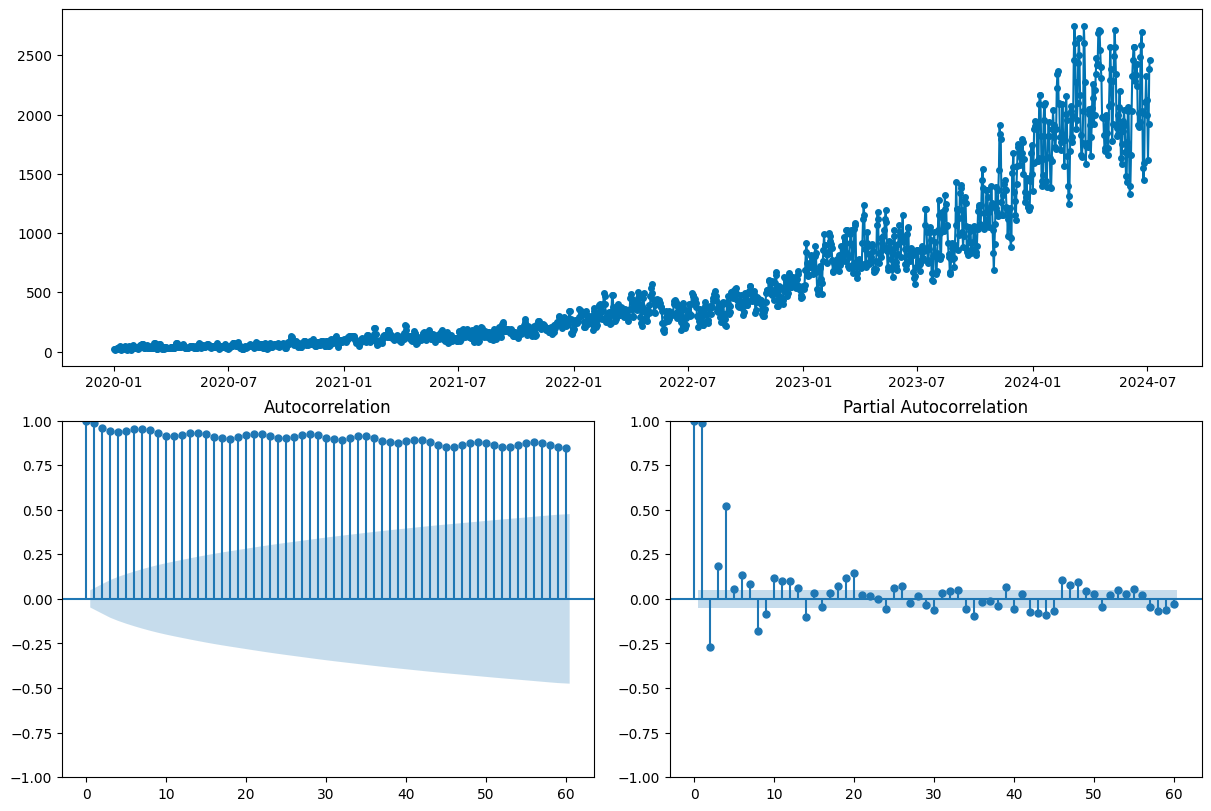

In [2]:
from sktime.utils.plotting import plot_correlations


fig, ax = plot_correlations(y_train, lags=60)
fig.show()

No gráfico de autocorrelação, vemos algumas características interessantes:

1. Valores são extremamente altos, e decaem lentamente ao longo do tempo.
2. Existem oscilações claras, indicando padrões sazonais na série temporal.

::: {.callout-tip}


É um erro comum usar a correlação de lags de uma série para seleção de variáveis (lags). Sempre que possível, devemos eliminar a tendência antes de analisar a autocorrelação.

::: 

Veremos que esses padrões são indicativos de que a série temporal possui componentes importantes, e que valores passados dizem muito sobre valores futuros.

## Componentes de séries temporais

Séries temporais podem ser decompostas em 3 componentes principais:

* Tendência: padrão de longo prazo na série temporal
* Sazonalidade: padrões que se repetem em intervalos regulares, como diariamente, semanalmente ou anualmente
* Ruído: variação aleatória que não pode ser explicada pelos outros componentes

Uma série aditiva pode ser representada como:

$$
Y(t) = T(t) + S(t) + R(t)
$$

onde $T(t)$ é a tendência, $S(t)$ é a sazonalidade, e $R(t)$ é o ruído. 

Em séries aditivas, o impacto da sazonalidade se dá em termos absolutos, dizemos: "em janeiro, as vendas aumentam em 100 unidades com relação a média do ano".

Mas também existem séries multiplicativas, onde os componentes interagem de forma diferente:

$$
Y(t) = T(t) \cdot S(t) \cdot R(t)
$$


Nessas séries, o impacto da sazonalidade se dá em termos relativos, dizemos: "em janeiro, as vendas aumentam em 20% com relação a média do ano". Esse é o caso mais comum para séries não-negativas, como vendas. Isso vem por definição: se temos vendas muito baixas, por exemplo, 10 unidades, não faz sentido dizer que em janeiro as vendas diminuem em 100 unidades, pois isso levaria a vendas negativas. Já dizer que as vendas diminuem em 20% é perfeitamente razoável.


::: {.callout-tip}

Em alguns casos, as séries multiplicativas são definidas como:

$$
Y(t) = T(t) + T(t) \cdot S(t) + T(t) \cdot R(t)
$$

:::


Quando a série é multiplicativa, podemos fazer recurso ao logaritmo para transformá-la em aditiva:

$$
log(Y(t)) = log(T(t)) + log(S(t)) + log(R(t))
$$

Para fazer isso no sktime, usamos o transformador `LogTransformer`. Transformadores são usados para pré-processar ou pós-processar os dados antes de aplicar um modelo de previsão, e sua interface é similar a dos modelos de previsão:

* `__init__`: define os hiperparâmetros do transformador
* `fit`: aprende os parâmetros do transformador a partir dos dados
* `transform`: aplica a transformação nos dados
* `inverse_transform` (opcional): aplica a transformação inversa nos dados


In [3]:
from sktime.transformations.series.boxcox import LogTransformer
log_transformer = LogTransformer()
log_transformer.fit(y_train)

LogTransformer()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

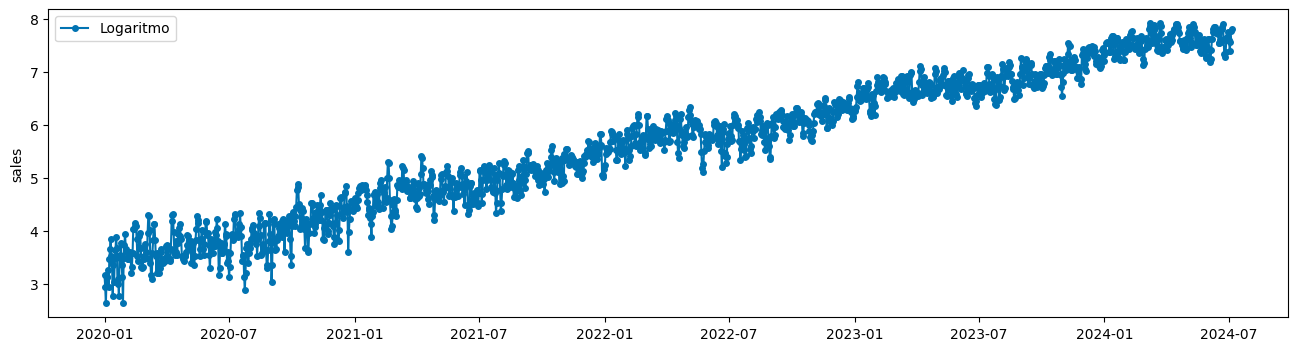

In [4]:
y_train_log = log_transformer.transform(y_train)
plot_series(y_train_log, labels=["Logaritmo"])

Ainda que não esteja perfeito, essa transformação estabiliza as variações da série temporal, o que é importante para alguns modelos de previsão.


### Decompondo a série temporal


Sktime fornece algumas opções para decompor séries temporais. Aqui, vamos usar o `Detrender` para remover a tendência, e o `Deseasonalizer` para remover a sazonalidade.

#### Tendência

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

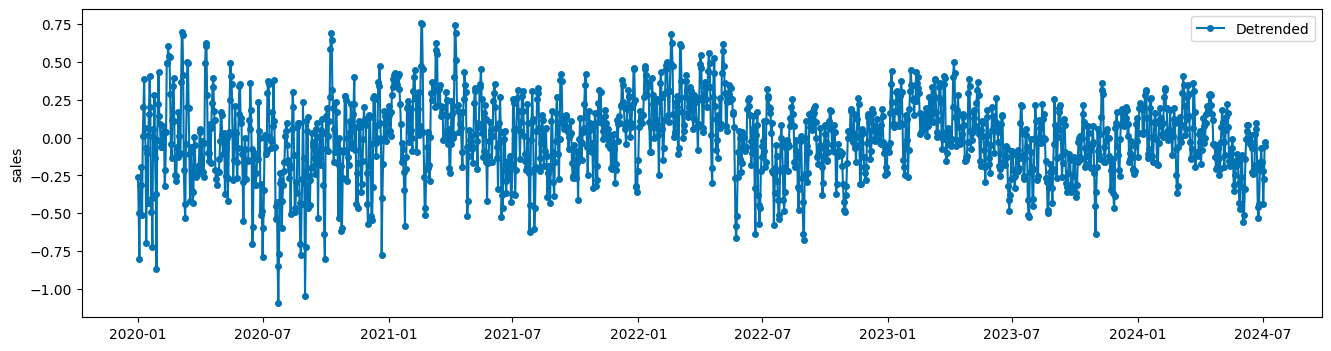

In [5]:
from sktime.transformations.series.detrend import Detrender, Deseasonalizer


detrender = LogTransformer() * Detrender(model="additive")
detrender.fit(y_train)
y_train_detrended = detrender.transform(y_train)
plot_series(y_train_detrended, labels=["Detrended"])

Vemos uma mudança importante no gráfico de autocorrelação:

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_35862/935228866.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


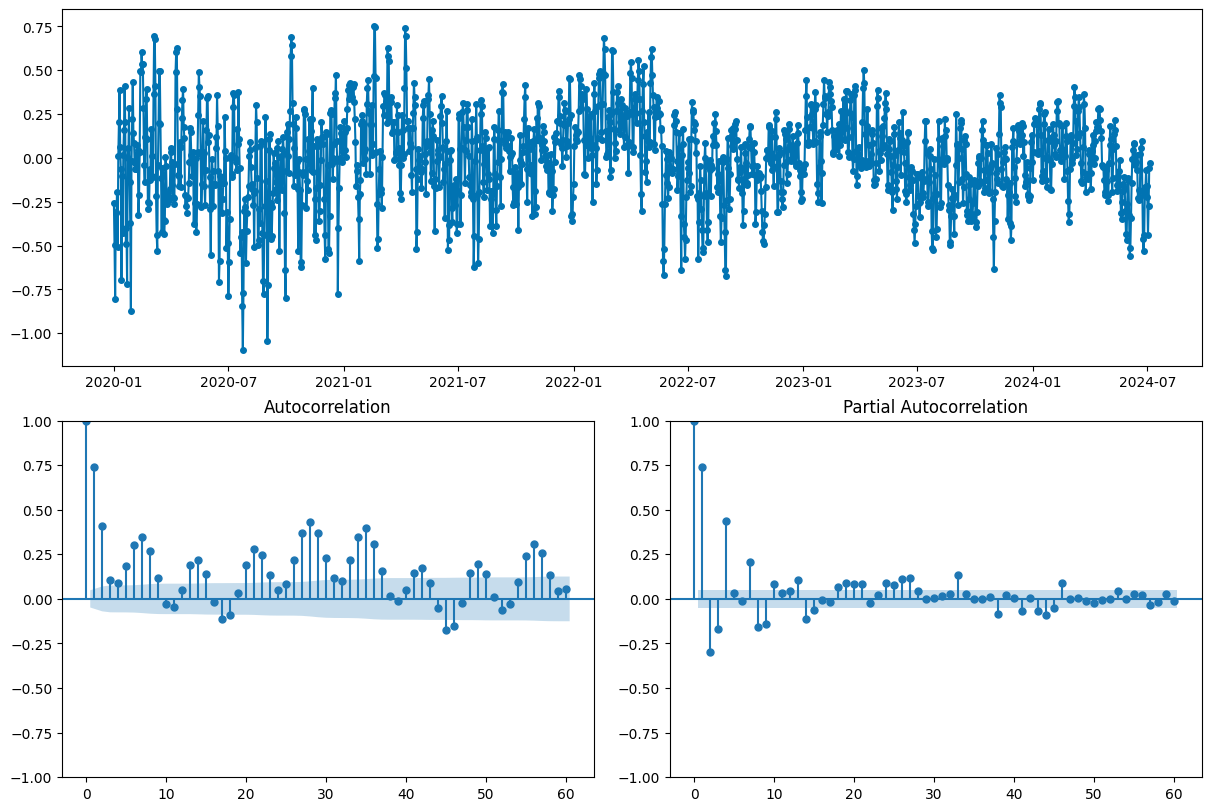

In [6]:
fig, _ = plot_correlations(y_train_detrended, lags=60)
fig.show()

O que indica que, ao eliminar a tendencia, a informação que o passado carrega sobre o futuro diminuiu bastante. Na verdade, a existência da tendência - um efeito de longo prazo - faz com que valores passados sejam altamente correlacionados com valores futuros, e pode dar a falsa impressão de que a série é "fácil" de modelar.


#### Sazonalidade

Agora, usamos o `Deseasonalizer` para remover a sazonalidade:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

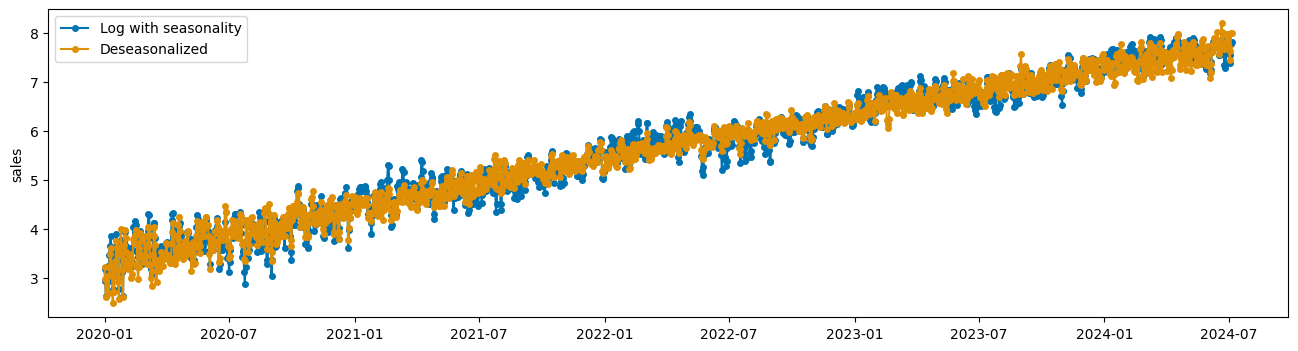

In [7]:
deseasonalizer = LogTransformer() * Deseasonalizer(model="additive", sp=365)
deseasonalizer.fit(y_train)
y_train_deseasonalized = deseasonalizer.transform(y_train)
plot_series(y_train_log, y_train_deseasonalized, labels=["Log with seasonality", "Deseasonalized"])

Podemos usar o `Detrender` e o `Deseasonalizer` juntos para remover ambos os componentes:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

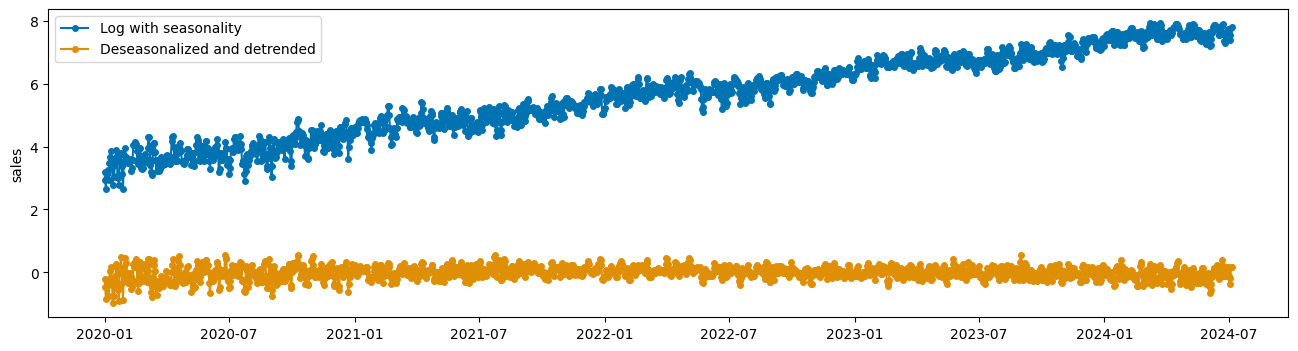

In [8]:
remove_components = LogTransformer() * Detrender(model="additive") * Deseasonalizer(model="additive", sp=365) 
remove_components.fit(y_train)
y_train_removed = remove_components.transform(y_train)
plot_series(y_train_log, y_train_removed, labels=["Log with seasonality", "Deseasonalized and detrended"])

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_35862/10449850.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


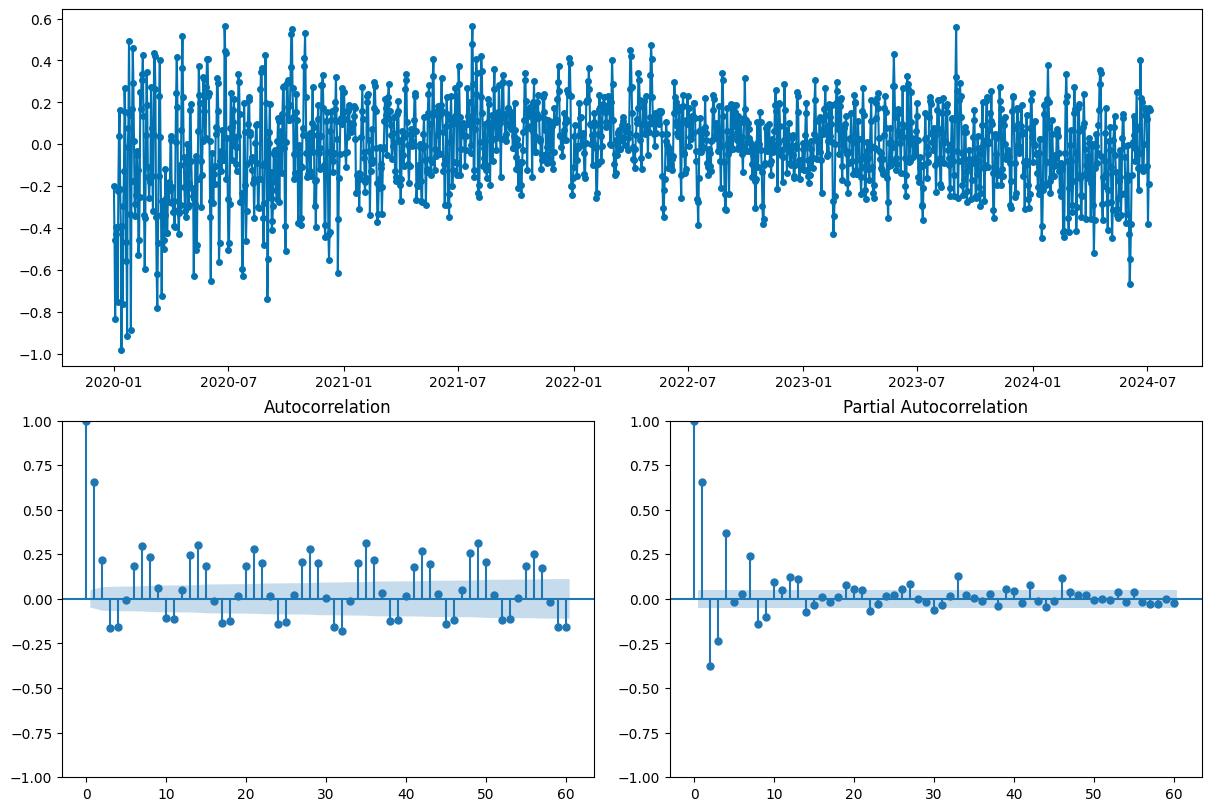

In [9]:
fig, _ = plot_correlations(y_train_removed, lags=60)
fig.show()

::: {.callout-tip}
Tente adicionar mais um deseasonalizer para remover a sazonalidade semanal.
:::

## Séries estacionárias

O conceito de estacionariedade é fundamental em séries temporais. Uma série temporal é dita estacionária se suas propriedades estatísticas, como média, variância e autocovariância, são constantes ao longo do tempo, não importando a janela e quando ela é observada.


::: .{.callout-tip}

Mais precisamente, se $Y(t)$, onde $t$ é o indice temporal, então dizemos que ela é estacionária se:

$$
P(Y(t_{start}:t_{end})) = P(Y(t_{start}+k:t_{end}+k)), \quad \forall k, t_{start}, t_{end} \in \mathbb{Z}
$$

:::

Claramente, a série temporal que estamos analisando não é estacionária. Basta percebermos que para valores maiores de $t$, a média e a variância são maiores.

O aumento da média da série ao longo do tempo é chamado de **tendência**. A tendência é um padrão de longo prazo na série temporal, e um grande desafio para previsões de longo prazo.

Existem definições mais "suaves" de estacionariedade, como a estacionariedade fraca, que requer apenas que propriedades como média e autovariância sejam constantes ao longo do tempo. 

No fundo, o que nos interessa mais é ter uma série temporal que seja "fácil"de modelar. Para alguns algoritmos, como Naive, é importante que ela seja o mais próxima possível de estacionária. Veja abaixo o problema geraodo quando aplicamos o modelo Naive diretamente na série temporal original.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

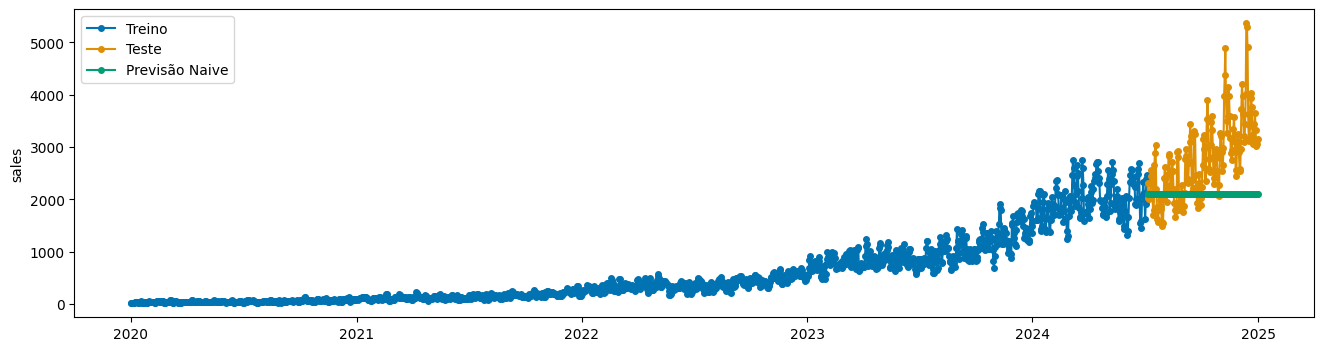

In [10]:
from sktime.forecasting.naive import NaiveForecaster

naive = NaiveForecaster(strategy="mean", window_length=24)
naive.fit(y_train)
y_pred = naive.predict(fh=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão Naive"])

### Diferenciação

Uma técnica simples e eficaz para lidar com séries não estacionárias é a diferenciação. Calculamos:

$$
Y'(t) = Y(t) - Y(t-1)
$$

e fazemos previsões em $Y'(t)$ ao invés de $Y(t)$. Para obter a previsão de $Y(t)$, precisamos fazer o processo inverso: somar a previsão de $Y'(t)$ com o valor anterior de $Y(t-1)$.

$$
\hat{Y(t)} = \hat{Y'}(t) + \hat{Y}(t-1), \quad \hat{Y}(0) \text{ conhecido}
$$

Com sktime, isso é extremamente fácil. Aqui, vamos usar um **transformador** chamado `Differencer`.

In [11]:
from sktime.transformations.series.difference import Differencer
diff = Differencer()
diff.fit(y_train)

Differencer()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

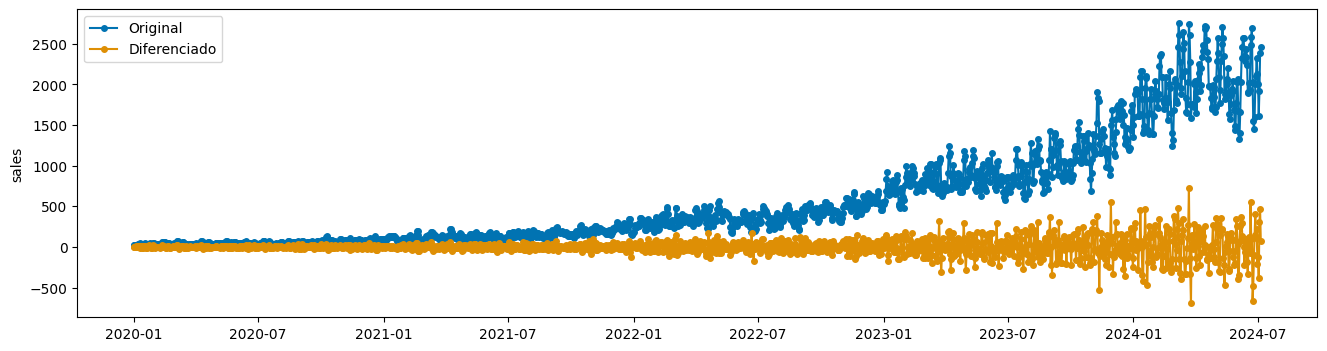

In [12]:
y_train_diff = diff.transform(y_train)

plot_series(y_train, y_train_diff, labels=["Original", "Diferenciado"])

## Criando um pipeline com diferenciação e Naive

Agora, podemos criar um modelo de forecasting mais complexo, composto por dois passos:

* Diferenciação dos dados
* Modelo Naive aplicado nos dados diferenciados

Para isso, usamos a classe `TransformedTargetForecaster`, que cria um pipeline de transformadores e um modelo de previsão.

In [13]:
from sktime.forecasting.compose import TransformedTargetForecaster

model = TransformedTargetForecaster(steps=[
    ("differencer", Differencer()),
    ("naive", NaiveForecaster(strategy="mean", window_length=24))
])
model.fit(y_train)

TransformedTargetForecaster(steps=[('differencer', Differencer()),
                                   ('naive',
                                    NaiveForecaster(strategy='mean',
                                                    window_length=24))])

Ou apenas:

In [14]:
model = Differencer() * NaiveForecaster(strategy="mean", window_length=24)
model.fit(y_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   NaiveForecaster(strategy='mean',
                                                   window_length=24)])

E agora podemos prever:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

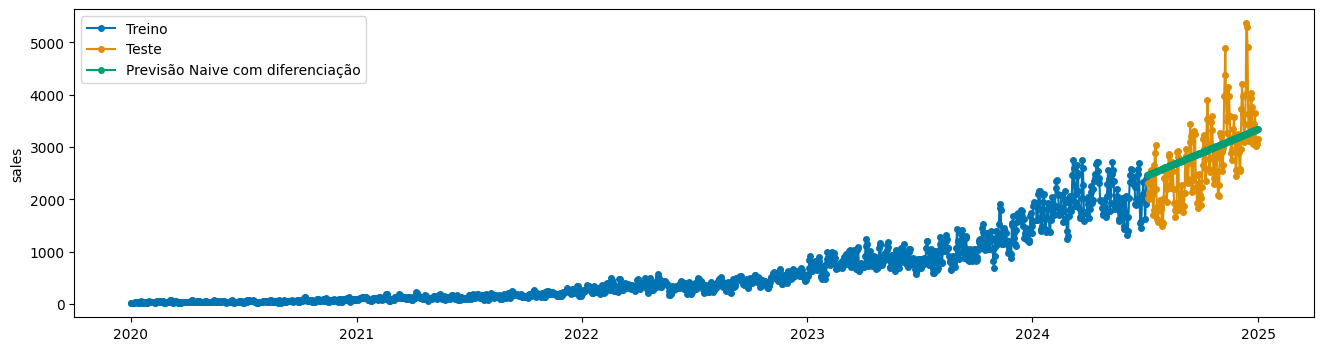

In [15]:
y_pred = model.predict(fh=y_test.index)
plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão Naive com diferenciação"])

Existem ainda alguns problemas com a diferenciação. Note que a variância da série temporal diferenciada não é constante ao longo do tempo. Aqui, podemos combinar nossa transformação logarítmica com a diferenciação. 

Primeiro, vamos criar um transformador que combina as duas transformações:

In [16]:
from sktime.transformations.compose import TransformerPipeline

log_diff = TransformerPipeline(steps=[
    ("log", LogTransformer()),
    ("diff", Differencer())
])
log_diff.fit(y_train)

TransformerPipeline(steps=[('log', LogTransformer()), ('diff', Differencer())])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

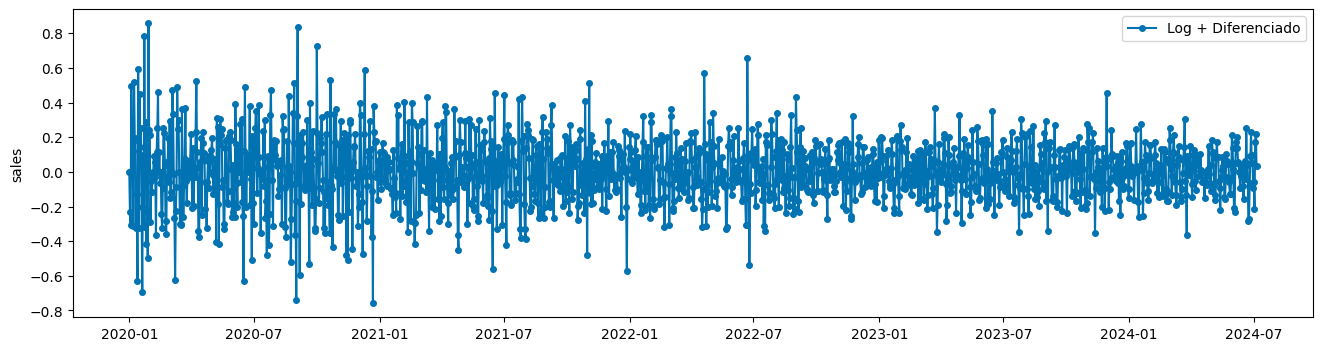

In [17]:
y_train_log_diff = log_diff.transform(y_train)
plot_series(y_train_log_diff, labels=["Log + Diferenciado"])

Para fazer forecast, criamos um pipeline com o transformador combinado e o modelo Naive:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

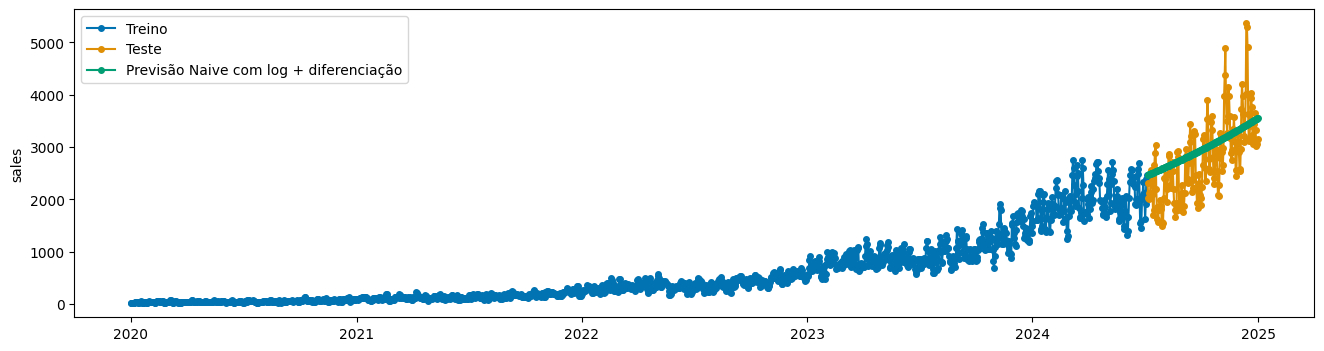

In [18]:
model = log_diff * NaiveForecaster(strategy="mean", window_length=24)
model.fit(y_train)
y_pred = model.predict(fh=y_test.index)
plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão Naive com log + diferenciação"])